<a href="https://colab.research.google.com/github/infeimkr/codeit_ai4/blob/main/%EB%AF%B8%EC%85%985_3%ED%8C%80_%EC%9E%84%EC%9D%B8%EC%B2%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 불러오기

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import cv2
import random
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from torch.optim.lr_scheduler import LambdaLR
from PIL import Image, ImageEnhance, ImageFilter
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import math

# 미션 설명

## 미션 소개
이번 미션에서는 손상된 문서를 복원하는 작업을 수행합니다. 오토인코더를 활용하여 문서 이미지의 품질을 향상시키고, 문서의 내용을 최대한 복원하는 모델을 구현해 봅시다. 문서는 습기, 찢김, 얼룩 등 다양한 이유로 손상될 수 있는데요. 이번 미션의 목표는 손상된 문서에서 노이즈를 제거하여 원본 문서를 최대한 복원하는 것입니다. 아래 데이터셋을 활용하여 다양한 복원 기법을 실험해보고, 성능을 평가해 보세요.

## 데이터 소개
 - 데이터 링크(Denoising Dirty Documents)
 - train: 손상된 문서(모델 훈련용)
 - train_cleaned: 손상된 문서의 원본(모델 훈련용)
 - test: 손상된 문서(모델 테스트용)

# 데이터 불러오기
 - 구글 드라이브에 데이터를 다운로드 받아 놓고, 로컬 환경에서도 같은 데이터를 이용할 수 있도록 구글드라이브 데스크 탑 버전으로 동기화 처리

In [5]:
if 'COLAB_RELEASE_TAG' in os.environ:
    check_google_colab = True
    print("온라인 Colab 환경(Google 서버)")
else:
    check_google_colab = False
    print("로컬 런타임 환경")

로컬 런타임 환경


In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    check_google_colab = True
    print("Google Colab 환경입니다.")
except ModuleNotFoundError:
    check_google_colab = False
    local_path = 'C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks'
    print("Local 환경입니다.")

Local 환경입니다.


 - 파일 경로 분기

In [ ]:
# 폴더 경로 설정
if check_google_colab:
    train_dirty_dir = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션5DATA/train"
    train_cleaned_dir = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션5DATA/train_cleaned"
    test_dir = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션5DATA/test"
    output_dir = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션5DATA/denoised_results"
else:
    train_dirty_dir = local_path+"/코드잇스프린트자료/미션/미션DATA/미션5DATA/train"
    train_cleaned_dir = local_path+"/코드잇스프린트자료/미션/미션DATA/미션5DATA/train_cleaned"
    test_dir = local_path+"/코드잇스프린트자료/미션/미션DATA/미션5DATA/test"
    output_dir = local_path+"/코드잇스프린트자료/미션/미션DATA/미션5DATA/denoised_results"

In [ ]:
print(train_dirty_dir)

/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션5DATA/train


 - 이미지 불러와서 리스트에 넣어서 확인

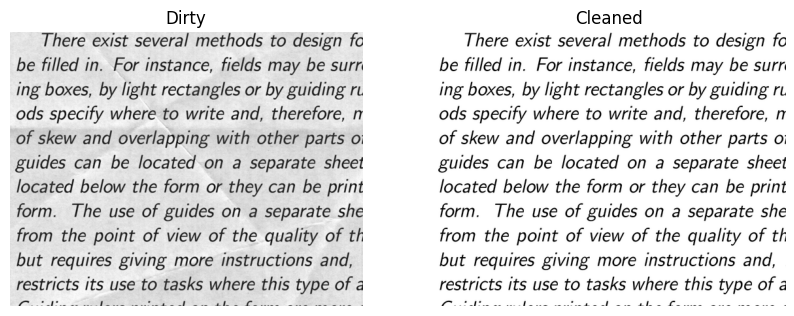

In [ ]:
def load_images_from_folder_sorted(folder):
    images = []
    filenames = sorted([f for f in os.listdir(folder) if f.endswith(".png")])
    for filename in filenames:
        img_path = os.path.join(folder, filename)

        img_data = np.fromfile(img_path, np.uint8)  # 파일을 byte 배열로 로드
        img = cv2.imdecode(img_data, cv2.IMREAD_COLOR)  # OpenCV 이미지 디코딩
        images.append(img)
    return images, filenames

# 이미지 불러오기
train_dirty_images, dirty_filenames = load_images_from_folder_sorted(train_dirty_dir)
train_cleaned_images, clean_filenames = load_images_from_folder_sorted(train_cleaned_dir)
test_images, test_filenames = load_images_from_folder_sorted(test_dir)

#시각화
dirty_img = train_dirty_images[0]
clean_img = train_cleaned_images[0]

plt.figure(figsize=(10, 5))

# Dirty 이미지
plt.subplot(1, 2, 1)
plt.imshow(dirty_img)
plt.title("Dirty")
plt.axis("off")

# Cleaned 이미지
plt.subplot(1, 2, 2)
plt.imshow(clean_img)
plt.title("Cleaned")
plt.axis("off")

plt.show()

In [ ]:
print(train_dirty_images[0].dtype)

uint8


In [ ]:
print(len(train_dirty_images))
print(len(train_cleaned_images))
print(len(test_images))

144
144
72


In [ ]:
print(type(train_dirty_images[0]))
print(type(train_cleaned_images[0]))
print(type(test_images[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 - 패딩을 위해 이미지들의 가로, 세로 사이즈를 확인해서 가장 큰 사이즈 찾기

In [ ]:
# 이미지 데이터 (가장 큰) 사이즈 확인 (목표 패딩 수치 확인용)
def get_unique_sizes(image_list):
    heights = [img.shape[0] for img in image_list]
    widths = [img.shape[1] for img in image_list]
    unique_heights = np.unique(heights)
    unique_widths = np.unique(widths)
    return unique_heights, unique_widths

train_h, train_w = get_unique_sizes(train_dirty_images)
train_cleaned_h, train_cleaned_w = get_unique_sizes(train_cleaned_images)
test_h, test_w = get_unique_sizes(test_images)

FIX_HEIGHT = max(np.max(train_h), np.max(train_cleaned_h), np.max(test_h))
FIX_WIDTH = max(np.max(train_w), np.max(train_cleaned_w), np.max(test_w))

print(f"패딩 목표 크기: {FIX_HEIGHT} x {FIX_WIDTH}")

패딩 목표 크기: 420 x 540


 - 최대값 => 420 * 540 으로 일괄 이미지 패딩 후 학습 예정

In [ ]:
#패딩 클래스
class PaddingC:
    def __init__(self, wSize=FIX_WIDTH, hSize=FIX_HEIGHT, fill=0):
        self.wSize = wSize
        self.hSize = hSize
        self.fill = fill  # padding color

    def pad(self, img):
        # img: PIL Image
        w, h = img.size

        pad_left = max((self.wSize - w) // 2, 0)
        pad_top = max((self.hSize - h) // 2, 0)
        pad_right = max(self.wSize - w - pad_left, 0)
        pad_bottom = max(self.hSize - h - pad_top, 0)

        padding = (pad_left, pad_top, pad_right, pad_bottom) # 혹시 몰라서...
        padded_img = transforms.functional.pad(img, padding, fill=self.fill)
        return padded_img, padding

## 데이터 셋 생성

In [ ]:
# 데이터 셋 설정
class DenoisingDocumentsDataset(Dataset): # 학습용 데이터 셋 클래스
    def __init__(self, train_dirty_images, train_cleaned_images, filenames,
                 transform_padding : PaddingC, transform_gray_to_tensor=None):
        self.train_dirty_images = train_dirty_images
        self.train_cleaned_images = train_cleaned_images
        self.filenames = filenames
        self.transform_padding = transform_padding
        self.transform_gray_to_tensor = transform_gray_to_tensor

    def __len__(self):
        return len(self.train_dirty_images)

    def __getitem__(self, idx):
        dirty_img = Image.fromarray(self.train_dirty_images[idx])
        clean_img = Image.fromarray(self.train_cleaned_images[idx])
        filename = self.filenames[idx]

        dirty_img, dirty_padding = self.transform_padding.pad(dirty_img)
        clean_img, clean_padding = self.transform_padding.pad(clean_img)

        if self.transform_gray_to_tensor is not None:
            dirty_img = self.transform_gray_to_tensor(dirty_img)
            clean_img = self.transform_gray_to_tensor(clean_img)

        return dirty_img, clean_img, filename

class DenoisingTestDataset(Dataset): # 최종 확인 데이터 셋 클래스
    def __init__(self, test_images, filename, transform_padding=None, transform=None):
        self.test_images = test_images
        self.filename = filename
        self.transform_padding = transform_padding
        self.transform = transform

    def __len__(self):
        return len(self.test_images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.test_images[idx])
        filename = self.filename[idx]

        if self.transform_padding is not None:
            img, _ = self.transform_padding.pad(img)

        if self.transform:
            img = self.transform(img)

        return img, filename

In [ ]:
pad_transform = PaddingC(FIX_WIDTH, FIX_HEIGHT, fill=0)

grayscale = transforms.Grayscale(num_output_channels=1)
to_tensor = transforms.ToTensor()

transform = transforms.Compose([
    grayscale,
    to_tensor,
])

dataset = DenoisingDocumentsDataset(
    train_dirty_images,
    train_cleaned_images,
    dirty_filenames,
    transform_padding=pad_transform,
    transform_gray_to_tensor=transform,
)

test_dataset = DenoisingTestDataset(
    test_images,
    test_filenames,
    transform_padding=pad_transform,
    transform=transform,
)


# 학습 데이터shape 확인
dirty_img, clean_img, filename = dataset[0]
print(dirty_img.shape, clean_img.shape, filename)

# 테스트 데이터shape 확인
test_img, filename = test_dataset[0]

print(test_img.shape)

print(f"전체 데이터셋 크기: {len(dataset)}")
print(f"결과적용 데이터셋 크기: {len(test_dataset)}")


torch.Size([1, 420, 540]) torch.Size([1, 420, 540]) 101.png
torch.Size([1, 420, 540])
전체 데이터셋 크기: 144
결과적용 데이터셋 크기: 72


In [ ]:
# 학습 데이터 셋 -> 학습 / 검증 으로 나눠두기
total_size = len(dataset)
val_size = int(total_size * 0.2)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 환경에 따라 배치 사이즈 변경
if check_google_colab:
    batch_size = 16
else:
    batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"학습 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(val_dataset)}")
print(f"batch_size: {batch_size}")

학습 데이터셋 크기: 116
검증 데이터셋 크기: 28
batch_size: 16


# 모델링
- AutoEncoder
    - CNN 구조 기반

        - 1차 모델링: 1 -> 32 -> 64 -> 128 -> 64 -> 32 -> 1
        결과: 에폭 20~ 이후 기울기 변화가 0.0005에서 거의 없음. 오히려 val 쪽이 미세하게 들쑥 날쑥.

        -> 결과적으로 일반화 성능을 강화하는게 좋을듯.

        - 2차 모델링: 일반화 대응을 위해 dropout 추가

        - 3차 모델링: 특징 강화를 위해 디코더시퀀서 끝단에 시그모이드 추가

        - 4차 모델링: BatchNorm2d 추가

        - 5차 모델링: 인코더 끝단, 디코더 첫단에 128 -> 128 Conv2d 레이어 추가. 커널 1, 패딩 0

        - 6차 모델링: dropout 수치 조정

        - 7차 모델링: 인코더에 Conv2d, 디코더에 ConvTranspose2d 각각 stride=2 로, 이미지 사이즈 변경 시도

        - 결과적으로 다운/업 스케일링 후 성능이 안좋아져서 포기

    - Unet 구조 기반
        - 8차 모델링: Unet 구조로 변경

        - 인코더 = 1 -> 32 -> 64 -> 128 (다운 스케일링 적용)
        - 보틀넥 = 256 -> 512
        - 디코더 = 256 -> 128 -> 64 -> 32 -> 1 (Unet 기반 업 스케일링 적용)

        - 9차 변경: MSE -> L1, Adam -> AdamW 변경    

In [ ]:
# 모델1 설계 --- 폐기
class Model_CNN(nn.Module):
    def __init__(self):
        super(Model_CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=6, stride=1, padding=3),  # 입력 1 → 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 64 → 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 128 → 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.15),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 256 → 512
            nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=0), # 512 → 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0, output_padding=0), # 256 → 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.15),

#            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),                              # 64 → 32
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0, output_padding=0), # 128 → 64
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 1, kernel_size=3, padding=1),  # 64 → 1
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(FIX_HEIGHT, FIX_WIDTH), mode='bilinear', align_corners=False)
        return x

In [ ]:
# 모델2 설계
class UNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self._block(1, 32)
        self.enc2 = self._block(32, 64)
        self.enc3 = self._block(64, 128)
        self.enc4 = self._block(128, 256)

        # Bottleneck
        self.bottleneck = self._block(256, 512)

        # Decoder
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(512, 256)  # 256 + 256

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(256, 128)  # 128 + 128

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(128, 64)  # 64 + 64

        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec4 = self._block(64, 32)   # 32 + 32

        self.final = nn.Conv2d(32, 1, kernel_size=1)

        self.sig = nn.Sigmoid()

    def _block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def decoder_layer(self, in_ch, e_layer, up_layer, dec_layer):
        out_ch = up_layer(in_ch)
        if out_ch.shape[2:] != e_layer.shape[2:]:
            out_ch = F.interpolate(out_ch, size=e_layer.shape[2:], mode='bilinear', align_corners=False)
        out_ch = torch.cat([out_ch, e_layer], dim=1)
        out_ch = dec_layer(out_ch)
        return out_ch

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))                   # input / 2
        e3 = self.enc3(F.max_pool2d(e2, 2))                   # input / 4
        e4 = self.enc4(F.max_pool2d(e3, 2))                   # input / 8

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))              # input / 16

        d1 = self.decoder_layer(b, e4, self.up1, self.dec1)   # input / 16 * 2
        d2 = self.decoder_layer(d1, e3, self.up2, self.dec2)  # input / 16 * 4
        d3 = self.decoder_layer(d2, e2, self.up3, self.dec3)  # input / 16 * 8
        d4 = self.decoder_layer(d3, e1, self.up4, self.dec4)  # input / 16 * 16

        fin = self.final(d4)

        return self.sig(fin)

# 학습 진행

In [ ]:
# 환경에 따라 배치 사이즈, 러닝레이트 변경
if check_google_colab:
    EPOCHS = 80
    LEARNING_RATE = 3e-3 # 테스트 결과 로컬과 같은 값으로 적용
else:
    EPOCHS = 40
    LEARNING_RATE = 3e-3

warmup_steps = int(len(train_loader) * EPOCHS * 0.15)
total_steps = EPOCHS * len(train_loader)

# Warmup + CosineAnnealing 함수
def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# criterion = nn.MSELoss()  # MSE
criterion = nn.L1Loss()  # L1

# 모델 선언
# model = Model_CNN().to(device) #모델1
model = UNetLike().to(device) #모델2
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE) # AdamW

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

print(f"Using device: {device}")

Using device: cuda


In [ ]:
# 학습
def calculate_psnr(img1, img2): #PSNR 계산
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return torch.tensor(float('inf'))
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr

global_step = 0
train_losses = []
lrs = []
val_losses = []
val_psnrs = []

for epoch in range(EPOCHS):
    train_loss = 0.0
    total_samples = 0


    model.train()
    for dirty, clean, filename in train_loader:
        dirty, clean = dirty.to(device), clean.to(device)

        optimizer.zero_grad()
        output = model(dirty)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        scheduler.step()

        lrs.append(optimizer.param_groups[0]['lr'])

        bs = dirty.size(0)

        global_step += 1

        train_loss += loss.item() * bs
        total_samples += bs

    train_losses.append(loss.item())
    avg_train_loss = train_loss / total_samples

    val_results = []
    val_loss = 0
    val_psnr = 0
    val_samples = 0

    model.eval()
    with torch.no_grad():
        for dirty, clean, filename in val_loader:
            dirty, clean = dirty.to(device), clean.to(device)
            output = model(dirty)
            bs = dirty.size(0)

            loss = criterion(output, clean)
            val_loss += loss.item() * bs

            for i in range(bs):
                val_psnr += calculate_psnr(output[i].unsqueeze(0), clean[i].unsqueeze(0)).item()

            val_samples += bs

            # 검증 출력용
            val_results.extend([
                (d.detach().cpu(), c.detach().cpu(), o.detach().cpu(), fn)
                for d, c, o, fn in zip(dirty, clean, output, filename)
            ])
        val_losses.append(loss.item())
        val_psnrs.append(val_psnr / val_samples)

    avg_val_loss = val_loss / val_samples
    avg_val_psnr = val_psnr / val_samples

    current_lr = optimizer.param_groups[0]['lr']

    if (epoch) % 5 == 0 or (epoch + 1) == EPOCHS:
        print(f"[Epoch {epoch+1}/{EPOCHS}] LR:{current_lr:.6f} "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val PSNR: {avg_val_psnr:.2f} dB | "
              f"TL - VL: {(train_loss - val_loss):.4f}")

[Epoch 1/80] LR:0.000250 Train Loss: 0.4239 | Val Loss: 0.4350 | Val PSNR: 7.02 dB | TL - VL: 36.9923
[Epoch 6/80] LR:0.001500 Train Loss: 0.1647 | Val Loss: 0.1482 | Val PSNR: 15.89 dB | TL - VL: 14.9600
[Epoch 11/80] LR:0.002750 Train Loss: 0.0603 | Val Loss: 0.0712 | Val PSNR: 21.96 dB | TL - VL: 5.0015
[Epoch 16/80] LR:0.002974 Train Loss: 0.0218 | Val Loss: 0.0238 | Val PSNR: 29.15 dB | TL - VL: 1.8606
[Epoch 21/80] LR:0.002872 Train Loss: 0.0151 | Val Loss: 0.0139 | Val PSNR: 32.60 dB | TL - VL: 1.3565
[Epoch 26/80] LR:0.002697 Train Loss: 0.0113 | Val Loss: 0.0108 | Val PSNR: 33.68 dB | TL - VL: 1.0081
[Epoch 31/80] LR:0.002458 Train Loss: 0.0090 | Val Loss: 0.0087 | Val PSNR: 34.74 dB | TL - VL: 0.8031
[Epoch 36/80] LR:0.002169 Train Loss: 0.0095 | Val Loss: 0.0104 | Val PSNR: 32.26 dB | TL - VL: 0.8076
[Epoch 41/80] LR:0.001843 Train Loss: 0.0081 | Val Loss: 0.0071 | Val PSNR: 35.54 dB | TL - VL: 0.7383
[Epoch 46/80] LR:0.001500 Train Loss: 0.0078 | Val Loss: 0.0092 | Val PSNR

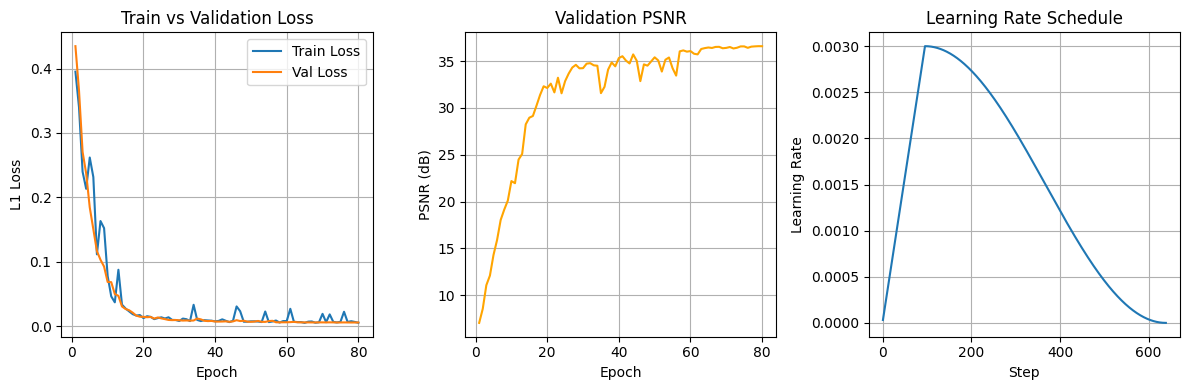

In [ ]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,3,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

# PSNR
plt.subplot(1,3,2)
plt.plot(epochs, val_psnrs, label='Val PSNR', color='orange')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)

# LRs
plt.subplot(1,3,3)
plt.plot(lrs)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.tight_layout()
plt.show()

## 모델 검증 시각화

In [ ]:
# 원본 vs 클린(학습용) vs 결과(검증)
def show_val_results(val_results, num_samples=3):
    samples = random.sample(val_results, num_samples)

    fig, axes = plt.subplots(num_samples, 3, figsize=(9, num_samples * 3))
    if num_samples == 1:
        axes = [axes]

    for i, (dirty_img, clean_img, pred_img, filename) in enumerate(samples):
        dirty_img = dirty_img.squeeze().numpy()
        clean_img = clean_img.squeeze().numpy()
        pred_img = pred_img.squeeze().numpy()

        # 원본
        axes[i][0].imshow(dirty_img, cmap='gray')
        axes[i][0].set_title(f"Dirty({filename})")
        axes[i][0].axis("off")

        axes[i][1].imshow(clean_img, cmap='gray')
        axes[i][1].set_title("Clean")
        axes[i][1].axis("off")

        axes[i][2].imshow(pred_img, cmap='gray')
        axes[i][2].set_title("Predicted")
        axes[i][2].axis("off")

    plt.tight_layout()
    plt.show()

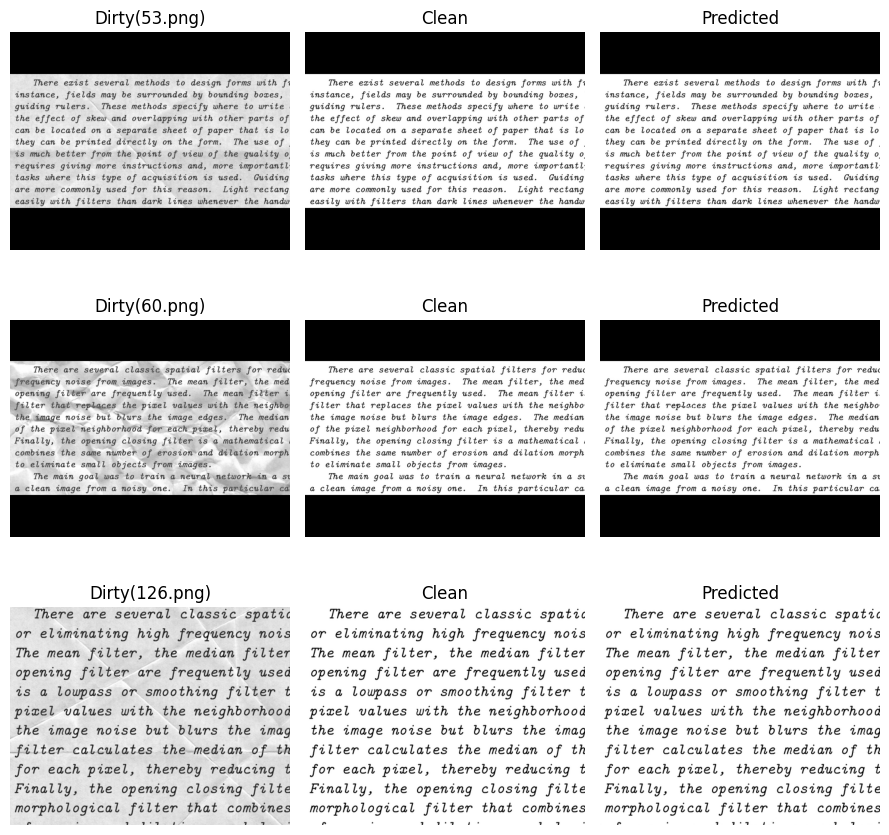

In [ ]:
# 랜덤 샘플 = 3
show_val_results(val_results, num_samples=3)

# 결과 확인

In [ ]:
# 결과 이미지 저장
os.makedirs(output_dir, exist_ok=True)

model.eval()
with torch.no_grad():
    for img, filename in test_loader:
        img = img.to(device)
        output = model(img)
        output = output.cpu()

        for i in range(output.size(0)):
            denoised = output[i]
            # tensor -> PIL 이미지 변환
            denoised_pil = TF.to_pil_image(denoised.squeeze())
            denoised_pil.save(os.path.join(output_dir, f"{filename[i]}"))


In [ ]:
# 원본 vs 디노이즈드 시각화
def show_denoised_results(output_dir, test_dir, num_samples=1):
    sample_files = random.sample(os.listdir(output_dir), num_samples)

    fig, axes = plt.subplots(len(sample_files), 2, figsize=(9, 4 * num_samples))

    for i, sf in enumerate(sample_files):
        # 변환 이미지
        output_img_path = os.path.join(output_dir, sf)
        output_img = Image.open(output_img_path)

        # 원본 이미지
        original_img_path = os.path.join(test_dir, sf)
        original_img = Image.open(original_img_path)

        # 원본 표시
        axes[i][0].imshow(original_img, cmap='gray')
        axes[i][0].set_title(f"Original({sf})")
        axes[i][0].axis("off")

        # 변환 후 표시
        axes[i][1].imshow(output_img, cmap='gray')
        axes[i][1].set_title(f"Denoised({sf})")
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()

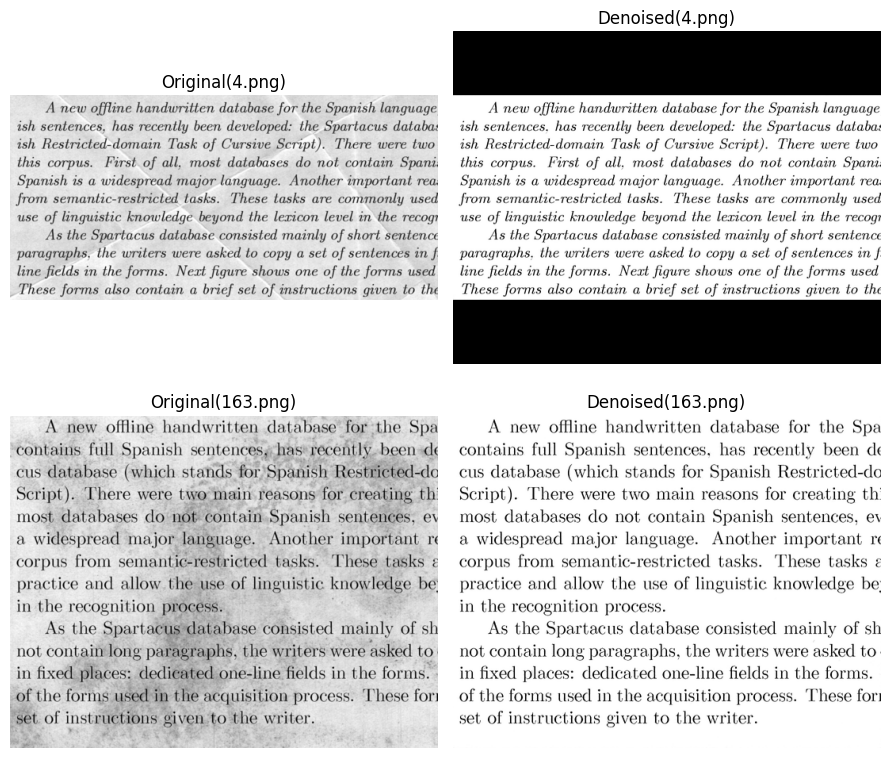

In [ ]:
# 랜덤 샘플 = 2
show_denoised_results(output_dir, test_dir, num_samples=2)

# 모델 서머리

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model, input_size=(batch_size, 1, FIX_HEIGHT, FIX_WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
UNetLike                                 [16, 1, 420, 540]         --
├─Sequential: 1-1                        [16, 32, 420, 540]        --
│    └─Conv2d: 2-1                       [16, 32, 420, 540]        320
│    └─BatchNorm2d: 2-2                  [16, 32, 420, 540]        64
│    └─ReLU: 2-3                         [16, 32, 420, 540]        --
│    └─Conv2d: 2-4                       [16, 32, 420, 540]        9,248
│    └─BatchNorm2d: 2-5                  [16, 32, 420, 540]        64
│    └─ReLU: 2-6                         [16, 32, 420, 540]        --
├─Sequential: 1-2                        [16, 64, 210, 270]        --
│    └─Conv2d: 2-7                       [16, 64, 210, 270]        18,496
│    └─BatchNorm2d: 2-8                  [16, 64, 210, 270]        128
│    └─ReLU: 2-9                         [16, 64, 210, 270]        --
│    └─Conv2d: 2-10                      [16, 64, 210, 270]        36,928
│ 